# Teleportation

Quantum information cannot be copied due to the *No Cloning Theorem*, however it can be "teleported" in the sense that a qubit can be entangled with a quantum resource, and via a protocol of measurements and *classical communication* of their results, the original quantum state can be reconstructed on a different qubit. This process destroys the information in the original qubit via measurement.

In this challenge, we will construct a particular qubit state and then transfer that state to another qubit using the teleportation protocol. Here we will be looking at specific classical and quantum registers, so we need to import those.

In [1]:
from qiskit.circuit import ClassicalRegister, QuantumRegister, QuantumCircuit

### Create the circuit

Define an angle $\theta$ to rotate our qubit by. This will allow us to easily make comparisons for the original state and the teleported state.

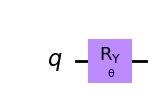

In [3]:
from qiskit.circuit import Parameter  # Import the Parameter class

theta = Parameter('θ')

qr = QuantumRegister(1, 'q')
qc = QuantumCircuit(qr)
qc.ry(theta, 0)
qc.draw('mpl')

Alice possesses the quantum information $|\psi\rangle$ in the state of $q$ and wishes to transfer it to Bob. The resource they share is a special entangled state called a Bell state
$$
|\Phi^+\rangle = \frac{1}{2} \left( |00\rangle + |11\rangle \right)
$$
with the first of the pair going to Alice and the second to Bob. Hence Alice has a 2-qubit register ($q$ and $Bell_0$) and Bob has a single-qubit register ($Bell_1$). We will construct the circuit by copying the original `qc` and adding the appropriate registers.

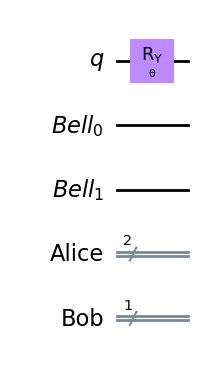

In [4]:
tele_qc = qc.copy()
bell = QuantumRegister(2, 'Bell')
alice = ClassicalRegister(2, 'Alice')
bob = ClassicalRegister(1, 'Bob')
tele_qc.add_register(bell, alice, bob)
tele_qc.draw('mpl')

Now create the Bell pair with $Bell_0$ going to Alice and $Bell_1$ going to Bob. This is done by using a Hadamard gate to put $Bell_0$ in the $|+\rangle$ state and then performing a CNOT with the same qubit as the control. After they receive their respective qubit, they part ways.

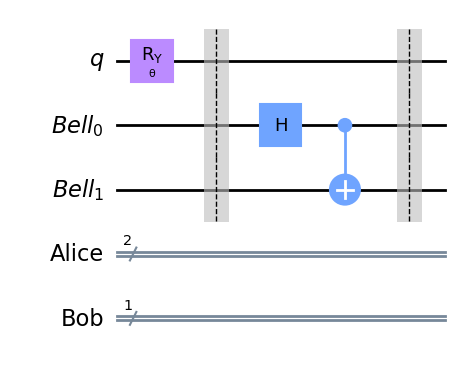

In [5]:
# create Bell state with other two qubits
tele_qc.barrier()
tele_qc.h(1)
tele_qc.cx(1, 2)
tele_qc.barrier()
tele_qc.draw('mpl')

Next, Alice performs a CNOT controlled by $q$ on $Bell_0$, which maps information about the state onto it. She then applies a Hadamard gate on $q$.

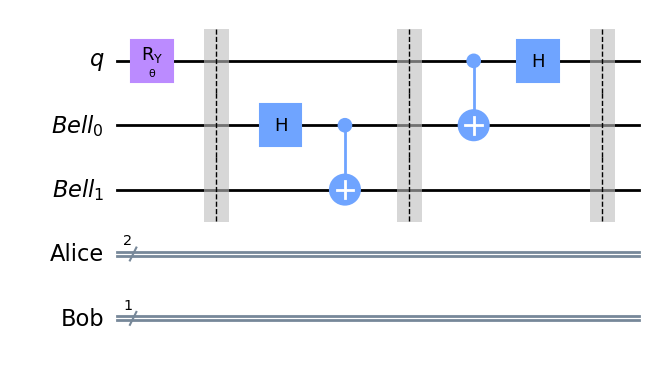

In [6]:
# alice operates on her qubits
tele_qc.cx(0, 1)
tele_qc.h(0)
tele_qc.barrier()
tele_qc.draw('mpl')

Now Alice measures her qubits and saves the results to her register.

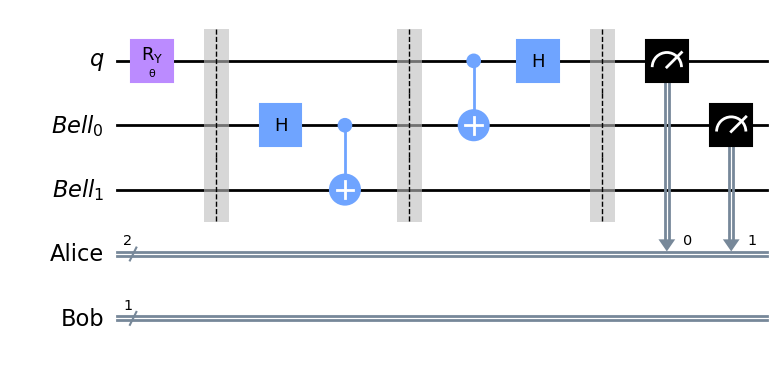

In [7]:
tele_qc.measure([qr[0], bell[0]], alice)
tele_qc.draw('mpl')

Bob's qubit now has the information $|\psi\rangle$ from Alice's qubit $q$ encoded in $Bell_1$, but he does not know what basis to measure in to extract it. Accordingly, Alice must share the information in her register over a *classical* communication channel (this is why teleportation does not violate special relativity, no matter how far Alice and Bob are apart). She instructs Bob to perform an X gate on his qubit if her measurement of $Bell_0$ yields a 1 outcome, followed by a Z gate if her measurement of $q$ yields a 1.

The applications of these gates can be conditioned on the measurement outcomes in two ways:
- the `.c_if()` [instruction](https://qiskit.org/documentation/stubs/qiskit.circuit.Instruction.c_if.html), which applies the gate it modifies if the value of the `ClassicalRegister` index is equal to the value specified. Note that this works **only** on simulators.
- the `.if_test()` [context](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.if_test.html) which operates similarly, but generalizes the syntax to allow for nested conditionals. This works on both simulators and actual hardware.

**STEP 4**: Add approriate conditional gates to transform Bob's qubit into the $Z$-basis.

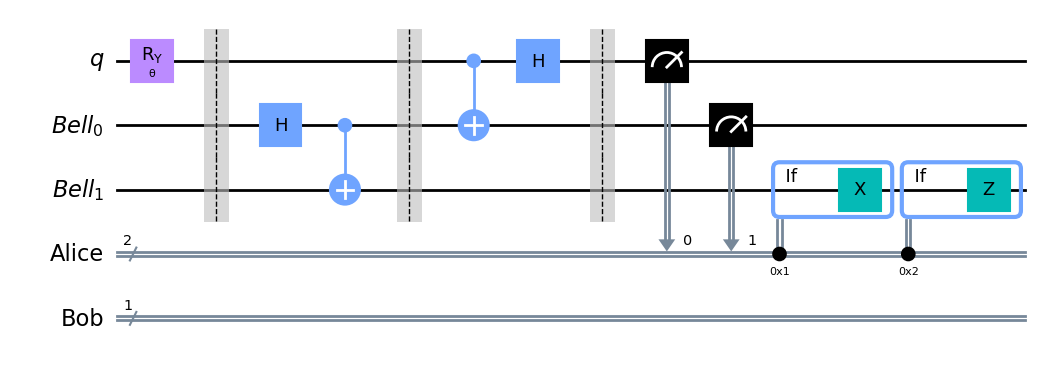

In [8]:
full_qc = tele_qc.copy()


#### ANSWER
# Apply X gate to Bob's qubit if Alice's measurement of Bell_0 is 1
with full_qc.if_test((alice, 1)):
    full_qc.x(2)

# Apply Z gate to Bob's qubit if Alice's measurement of q is 1
with full_qc.if_test((alice, 2)):
    full_qc.z(2)

#### END ANSWER


full_qc.draw('mpl')

Finally, Bob can measure his qubit, which would yield results with the same probabilities as had Alice measured it originally.

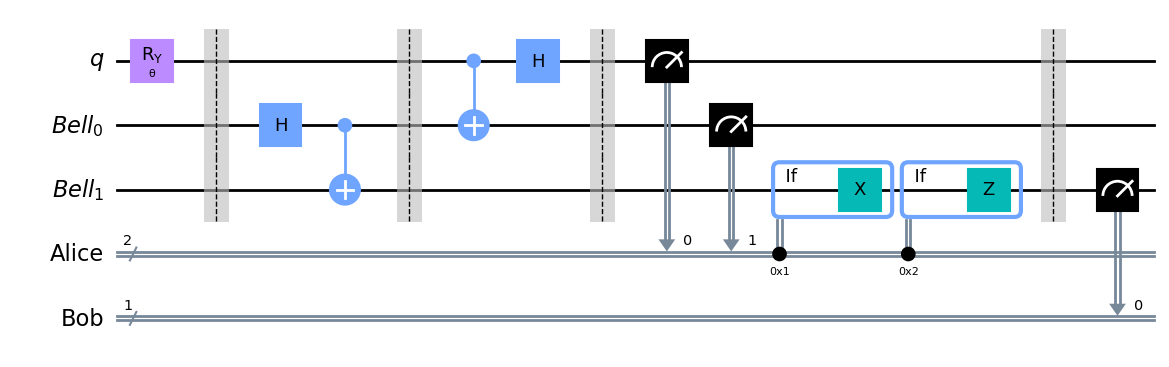

In [9]:
full_qc.barrier()
full_qc.measure(bell[1], bob)
full_qc.draw('mpl')

The statevector simulator cannot work with dynamic circuits because measurement is not a unitary operation. Therefore we import the `Sampler` primitive from `qiskit_aer` to use the `AerSimulator`. We choose our angle to be $5\pi/7$, which will yield a 1 result about 80\% of the time and 0 result about 20\% of the time. Then we run both circuits: the original one Alice had and the teleported one Bob receives. 

In [30]:
from qiskit_aer.primitives import Sampler
import numpy as np  # Import NumPy for mathematical operations


angle = 5*np.pi/7

sampler = Sampler()
qc.measure_all()
job_static = sampler.run(qc.bind_parameters({theta: angle}))
job_dynamic = sampler.run(full_qc.bind_parameters({theta: angle}))

print(f"Original Dists: {job_static.result().quasi_dists[0].binary_probabilities()}")
print(f"Teleported Dists: {job_dynamic.result().quasi_dists[0].binary_probabilities()}")

Original Dists: {'0000': 0.2119140625, '1111': 0.7880859375}
Teleported Dists: {'001': 0.18359375, '011': 0.208984375, '110': 0.0517578125, '100': 0.2109375, '101': 0.0390625, '010': 0.20703125, '000': 0.0439453125, '111': 0.0546875}


Wait, we see different results! While measuring Alice's original $q$ yields the expected ratio of outcomes, the teleported distributions have many more values. This is because the teleported circuit includes Alice's measurements of $q$ and $Bell_0$, whereas we only wish to see Bob's measurements of $Bell_1$ yield the same distribution. 

In order to rectify this, we must take the *marginal* counts, meaning we combine results in which Bob measures a 0 and all the results in which Bob measures a 1 over all the possible combinations. This is done with the `marginal_counts` [method](https://qiskit.org/documentation/stubs/qiskit.result.marginal_counts.html) from `qiskit.result`, which combines results over measurement indices.

**STEP 5**: Marginalize the teleported counts

Hint: Remember that bit strings are reported in the little-endian convention.

In [45]:
from qiskit.result import marginal_counts

# FILL IN CODE HERE
'''
tele_counts = # marginalize counts
'''

#### ANSWER
tele_counts = marginal_counts(job_dynamic.result().quasi_dists[0].binary_probabilities(), indices=[2])
#### END ANSWER



If we marginalized correctly, we will see that the quasi-distributions from Alice's measurement and Bob's measurement are nearly identical, demonstrating that teleportation was successful!

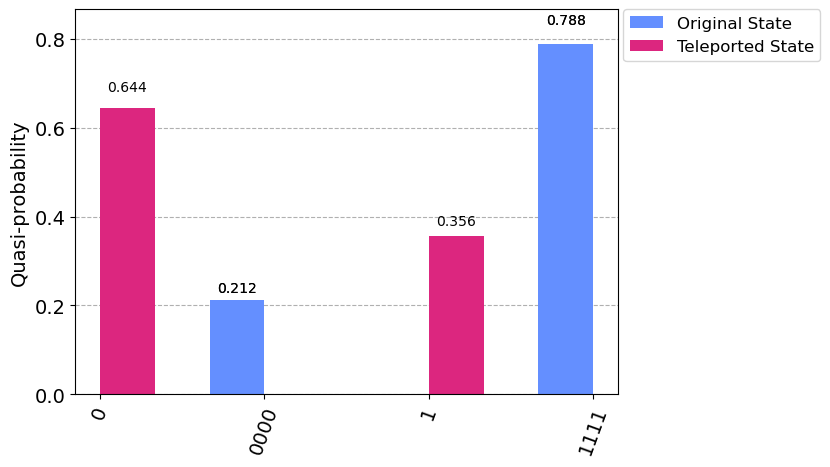

In [46]:
from qiskit.visualization import plot_histogram

legend = ['Original State', 'Teleported State']
plot_histogram([job_static.result().quasi_dists[0].binary_probabilities(), tele_counts], legend=legend)

In [44]:
import qiskit.tools.jupyter
%qiskit_version_table